# Retrieve Processed Data From GitHub

In [1]:
import requests
import io
import csv
import torch
import torchtext


def get_sentences():
    processed = [[], [], []]
    urls = []
    urls.append("https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/trainEncoded")
    urls.append("https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/validEncoded")
    urls.append("https://raw.githubusercontent.com/Niazitahir/SMS_Spam_Detection_APS360/main/RawData/testEncoded")
    raws = [requests.get(u).text for u in urls]
    separated = [csv.reader(io.StringIO(r)) for r in raws]
    for i in range(len(separated)):
        for row in separated[i]:
            idxs = row[2][1:-1].split(", ")
            if idxs[0] == "": continue
            idxs = list(map(int, idxs))
            idxs = [id % 10000 for id in idxs]
            idxs = torch.tensor(idxs)
            label = torch.tensor(int(row[1] == "[5721]")).long()
            processed[i].append((idxs, label))

    return processed[0], processed[1], processed[2] # Train, valid, test as [(tensor([idx]), tensor(label))]

# Create GRU and LSTM Network Models

In [2]:
import torch.nn as nn


class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove, num_layers=1):
        super(LSTMNet, self).__init__()
        self.name = "LSTM"
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x, h0c0=None):
        x = self.emb(x)
        out, _ = self.rnn(x, h0c0)
        out = self.fc(out[:, -1, :])
        return out

class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, glove, num_layers=1):
        super(GRUNet, self).__init__()
        self.name = "GRU"
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x, hidden=None):
        x = self.emb(x)
        out, _ = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out

# Batch Data With Same Length Randomly

In [3]:
import random


class Batcher:
    def __init__(self, sentences, batch_size=32, drop_last=False):
        self.batch_size = batch_size
        self.sentences_by_length = {}
        for sentence, label in sentences:
            len = sentence.size(0)
            if len not in self.sentences_by_length:
                self.sentences_by_length[len] = []

            self.sentences_by_length[len].append((sentence, label))

        self.loaders = {len : torch.utils.data.DataLoader(
                            sentences,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=drop_last)
                        for len, sentences in self.sentences_by_length.items()}


    def __iter__(self):
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)

            except StopIteration:
                iters.remove(im)

# Evaluate Model Accuracy on Selected Data

In [4]:
def get_accuracy(model, loader):
    correct, total = 0, 0
    for sentences, labels in loader:
        if torch.cuda.is_available():
            sentences = sentences.cuda()
            labels = labels.cuda()
        output = model(sentences)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.size(0)

    return correct / total

# Generate File Path to Save Network Model

In [5]:
def get_file_path(name, glove, hidden_size, num_layers, batch_size, learning_rate):
    path = "{0}_{1}_hs{2}_nl{3}_bs{4}_lr{5}_".format(name,
                                                     glove,
                                                     hidden_size,
                                                     num_layers,
                                                     batch_size,
                                                     learning_rate)
    return "/content/drive/MyDrive/Colab/" + path

# Train Network Model

In [6]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


def train_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc =[], [], []
    for epoch in range(num_epochs):
        for sentences, labels in train:
            if torch.cuda.is_available():
                sentences = sentences.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            pred = model(sentences)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        losses.append(float(loss))
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Valid Acc %f" % (
                epoch, loss, train_acc[-1], valid_acc[-1]))
        path = get_file_path(model.name,
                             "6B50",
                             model.hidden_size,
                             model.num_layers,
                             train.batch_size,
                             learning_rate)
        torch.save(model.state_dict(), path + str(epoch))

    np.savetxt("{}losses.csv".format(path), losses)
    np.savetxt("{}train.csv".format(path), train_acc)
    np.savetxt("{}valid.csv".format(path), valid_acc)

    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

# Create Objects and Run Functions

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fri Mar 22 00:46:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

.vector_cache/glove.6B.zip: 862MB [02:38, 5.43MB/s]                           
100%|█████████▉| 9999/10000 [00:00<00:00, 28417.14it/s]


CUDA is available! Training on GPU...
Epoch 0; Loss 0.792473; Train Acc 0.045312; Valid Acc 0.145258
Epoch 1; Loss 0.786482; Train Acc 0.044922; Valid Acc 0.145258
Epoch 2; Loss 0.764895; Train Acc 0.044141; Valid Acc 0.145258
Epoch 3; Loss 0.753253; Train Acc 0.043359; Valid Acc 0.145258
Epoch 4; Loss 0.735962; Train Acc 0.045312; Valid Acc 0.145258
Epoch 5; Loss 0.760984; Train Acc 0.045312; Valid Acc 0.145258
Epoch 6; Loss 0.697850; Train Acc 0.045312; Valid Acc 0.145258
Epoch 7; Loss 0.693846; Train Acc 0.515234; Valid Acc 0.563025
Epoch 8; Loss 0.653886; Train Acc 0.676562; Valid Acc 0.665066
Epoch 9; Loss 0.636138; Train Acc 0.763672; Valid Acc 0.713085
Epoch 10; Loss 0.745321; Train Acc 0.840625; Valid Acc 0.761104
Epoch 11; Loss 0.430163; Train Acc 0.835156; Valid Acc 0.761104
Epoch 12; Loss 0.375977; Train Acc 0.867969; Valid Acc 0.783914
Epoch 13; Loss 0.350999; Train Acc 0.907422; Valid Acc 0.810324
Epoch 14; Loss 0.396292; Train Acc 0.907422; Valid Acc 0.811525
Epoch 15; Lo

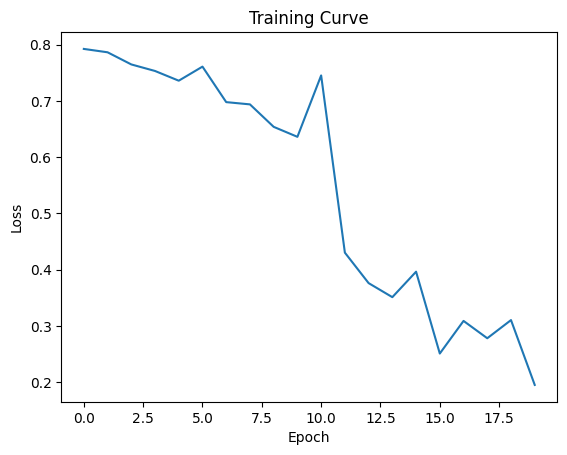

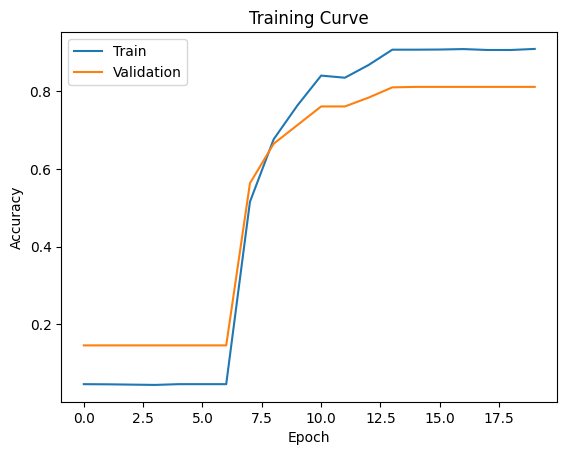

Test accuracy: 0.8082026537997588
Total number of parameters: 581702


In [8]:
# import torch.nn.functional as F

random.seed(69)
torch.manual_seed(420)

!nvidia-smi

glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)

model = LSTMNet(50, 50, 2, glove, num_layers=4)
if torch.cuda.is_available():
    model.cuda()
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

train, valid, test = get_sentences()

train_loader = Batcher(train, batch_size=64, drop_last=True)
valid_loader = Batcher(valid, batch_size=64, drop_last=False)
test_loader = Batcher(test, batch_size=64, drop_last=False)

train_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)

print("Test accuracy:", get_accuracy(model, test_loader))

size = 0
for param in model.parameters():
    size += torch.numel(param)
print("Total number of parameters:", size)

# Plot Training Curves of Selected Network Model

In [9]:
def plot_training_curves(path):
    losses = np.loadtxt("{}losses.csv".format(path))
    train_acc = np.loadtxt("{}train.csv".format(path))
    valid_acc = np.loadtxt("{}valid.csv".format(path))

    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

# Detect Spam on Sample SMS Message

In [10]:
def evaluate_sample(sample, model, glove):
    sentence = sample.replace(".", " . ") \
                        .replace(",", " , ") \
                        .replace(";", " ; ") \
                        .replace("?", " ? ")
    sentence = sentence.lower().split()
    idxs = torch.tensor([glove.stoi[w] for w in sentence if w in glove.stoi])
    if torch.cuda.is_available(): idxs = idxs.cuda()
    pred = model(idxs.unsqueeze(0)).max(1, keepdim=True)[1].item()
    return pred

# Create More Objects and Run More Functions

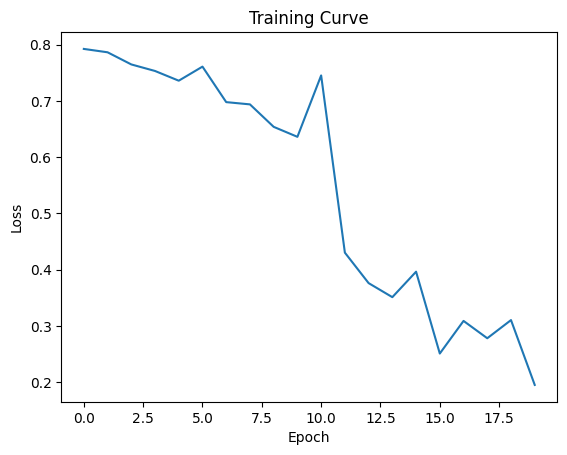

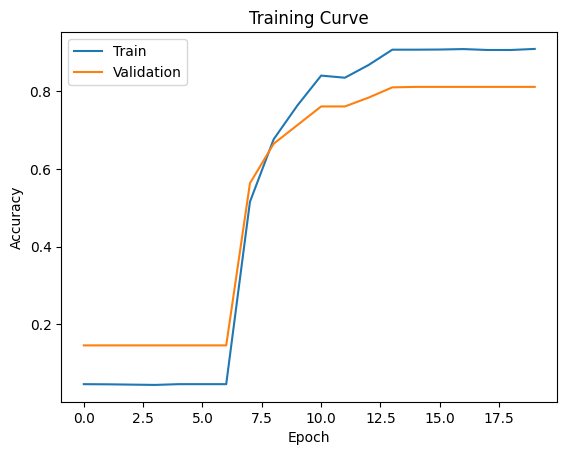

Ham


In [12]:
tuned_model = LSTMNet(50, 50, 2, glove, num_layers=4)
if torch.cuda.is_available(): tuned_model.cuda()
path = get_file_path("LSTM",
                     "6B50",
                     50,
                     4,
                     64,
                     2e-5)
tuned_model.load_state_dict(torch.load(path + "19"))

plot_training_curves(path)

# Sample message: "hi kate u give ring asap xxx"
pred = evaluate_sample("hi kate u give ring asap xxx", tuned_model, glove)
print("Ham") if pred else print("Spam")